In [24]:
import os
import pandas as pd

from qiskit.circuit import QuantumCircuit
import optuna
import qtpu
from qtpu.compiler.terminators import reach_num_qubits
from qtpu.compiler.success import success_num_nodes
from qtpu.compiler import trial_to_hybrid_tn

from benchmark._plot_util import *
from benchmark.util import get_hybrid_tn_info, append_to_csv, get_base_info
from benchmark.benchmarks import *

In [25]:
def get_highest_cost_trial(study: optuna.Study):
    return trial_to_hybrid_tn(
        max(study.best_trials, key=lambda t: (t.values[0], t.values[1]))
    )

In [27]:
circuit = cluster_ansatz(10 * [20], 5)

for cost in [1e6, 1e7]:
    htn = qtpu.cut(
        circuit,
        max_cost=cost,
        show_progress_bar=True,
        # terminate_fn=reach_num_qubits(20),
    )
    for qt in htn.quantum_tensors:
        print(qt.shape)

    # circuit = brick_ansatz(100, 3)
    # study = qtpu.compiler.hyper_optimize(
    #     circuit, max_cost=(5, cost), show_progress_bar=True
    # )

    # for trial in study.best_trials:
    #     htn = trial_to_hybrid_tn(trial)
    info = get_hybrid_tn_info(htn)
    base_info = get_base_info(circuit)
    append_to_csv(
        "results/fidelity2.csv",
        {
            "name": "brick_100_3",
            "given_cost": np.log10(cost),
            **info,
            **base_info,
        },
    )

  0%|          | 0/100 [00:00<?, ?it/s]

/home/nate/qvm/benchmark/util.py:76: RuntimeWarning: divide by zero encountered in log10
  ) + np.log10(len(hybrid_tn.classical_tensors) + len(hybrid_tn.quantum_tensors) - 1)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv("results/fidelity2.csv")

df["rel_cx"] = df["cx_count"] / df["base_cx_count"]
df

,name,given_cost,contract_cost,bruteforce_cost,num_qpds,num_subcircuits,num_instances,esp,depth,max_qubits,swap_count,cx_count,2q_count,base_qubits,base_depth,base_esp,base_swap_count,base_cx_count,base_2q_count,rel_cx
0,brick_100_3,2.0,2.158,1.681,2,2,32,0.099,112,100,0,2277,2277,100,112,0.099,0,2278,2278,0.999561
1,brick_100_3,3.0,3.151,2.602,3,2,200,0.249,111,60,0,1370,1370,100,112,0.099,0,2278,2278,0.601405
2,brick_100_3,4.0,3.151,2.602,3,2,200,0.249,111,60,0,1370,1370,100,112,0.099,0,2278,2278,0.601405
3,brick_100_3,5.0,4.112,5.602,7,4,10216,0.395,96,41,0,917,917,100,112,0.099,0,2278,2278,0.402546
4,brick_100_3,6.0,4.736,9.592,12,5,47125,0.626,79,20,0,462,462,100,112,0.099,0,2278,2278,0.202809
5,brick_100_3,7.0,4.736,9.592,12,5,47125,0.626,79,20,0,462,462,100,112,0.099,0,2278,2278,0.202809


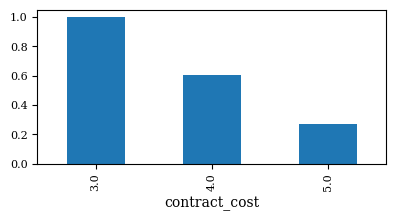

In [ ]:
names = ["brick_100_3"]

fig, axes = plt.subplots(1, len(names), figsize=(4.5, 2.0))
axes = [axes] if len(names) == 1 else axes


for name, ax in zip(names, axes):
    df_ = df[df["name"] == name]

    df_["contract_cost"] = np.ceil(df_["contract_cost"])
    df_ = df_[["contract_cost", "rel_cx"]]
    df_ = df_.groupby("contract_cost").mean().reset_index()
    # plot contract_cost on x-axis, esp on y-axis
    df_.plot.bar(x="contract_cost", y="rel_cx", ax=ax, legend=False)
    # ax.plot(df_["contract_cost"], df_["rel_cx"], label="ESP", marker="o")

fig;